### HW5Q3

In [1]:
import os
import numpy as np
import collections
import pickle
import argparse
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters used in code

In [46]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='/project2/cmsc25025/Shakespear/')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=3)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()

In [3]:
def timer(start, end):
    hrs, rem = divmod(end-start, 3600)
    mins, secs = divmod(rem, 60)
    print('{:0>2} hours {:0>2} minutes {:05.2f} seconds'.format(int(hrs), int(mins), secs))

In [4]:
class TextLoader():

    def __init__(self, data_dir, batch_size=64, seq_length=50, encoding='utf-8'):
        self.data_dir = data_dir
        self.encoding = encoding
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.input_file = os.path.join(data_dir, 'tinyshakespeare.txt')
        self.vocab_file = os.path.join(data_dir, 'vocab.pkl')
        # Numeric file of characters translated to indices.
        self.tensor_file = os.path.join(data_dir, 'data.npy')
        
        if not (os.path.exists(self.vocab_file) and os.path.exists(self.tensor_file)):
            print('it seems we havent processed the text data yet: reading the shakespear')
            self.preprocess(self.input_file, self.vocab_file, self.tensor_file)
        else:
            print('there are preprocessed data - lets load it')
            self.load_preprocessed(self.vocab_file, self.tensor_file)

        self.create_batches()
        self.reset_batch_pointer()

    # Create numeric file.
    def preprocess(self, input_file=None, vocab_file=None, tensor_file=None, saveit=True):
        if input_file is not None:
            self.input_file = input_file
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.input_file, 'r') as f:
            data = f.read()
        #data = data.lower()
        self.total_length = len(data)
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))

        if saveit:
            with open(self.vocab_file, 'wb') as f:  # saving dictionary so we don't compute it again
                pickle.dump(self.chars, f)
            self.tensor = np.array(list(map(self.vocab_to_idx.get, data)))
            np.save(self.tensor_file, self.tensor)  # saving the numerified data
    # Load numeric file create dictionaries for char2idx and back
    def load_preprocessed(self, vocab_file=None, tensor_file=None):
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.vocab_file, 'rb') as f:
            self.chars = pickle.load(f)

        # attributes
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(self.vocab_size)))
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))
            
    # tensor size = the length of the entire data sequence
    # divide into batch_size sub sequences and stack
    # cut those by seq_length to produce batches of [batch size, seq_length] sized examples
    def create_batches(self):

        
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        if self.num_batches == 0:
            assert False, 'Not enough data. Make seq_length and/or batch_size smaller'

        self.tensor = self.tensor[:self.num_batches * 
                                  self.batch_size * self.seq_length]  # so we get an even divide
        xdata = self.tensor
        ydata = np.copy(self.tensor)

        # ydata is one step ahead of x and last item is first item of x 
        # to get sequences of same length    
        ydata[:-1] = xdata[1:] 
        ydata[-1] = xdata[0]

        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
        
        self.train_num_batches=np.int32(self.num_batches*.8)
        self.test_num_batches=self.num_batches-self.train_num_batches
        self.train_x_batches=self.x_batches[0:self.train_num_batches]
        self.train_y_batches=self.y_batches[0:self.train_num_batches]
        self.test_x_batches=self.x_batches[self.train_num_batches:]
        self.test_y_batches=self.y_batches[self.train_num_batches:]

        # xdata: L length
        # xdata reshaped: batch_size, (L/batch_size) length following natural indexing
        # np.split: into num batches batches along the width(sentence)

    def next_batch_train(self):
        x, y = self.train_x_batches[self.pointer], self.train_y_batches[self.pointer]
        self.pointer += 1
        return x,y
    
    def next_batch_test(self):
        x, y = self.test_x_batches[self.pointer], self.test_y_batches[self.pointer]
        self.pointer += 1
        return x,y

    def reset_batch_pointer(self):
        self.pointer = 0

In [47]:
loader = TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)
args.num_chars = loader.vocab_size
print('num chars',args.num_chars)
print('num batches',loader.num_batches)

there are preprocessed data - lets load it
num chars 65
num batches 232


# Basic RNN

In [6]:
class MyBasicRNNCell(tf.contrib.rnn.BasicRNNCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        
        self.W = self.add_variable(name="W", shape=[input_depth + 
                                                    self._num_units, self._num_units])
        self.b = self.add_variable(name="b", shape=[self._num_units], 
                                   initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):
        """Most basic RNN: output = new_state = act(W * input + U * state + B)."""
        
        output = tf.tanh(tf.matmul(tf.concat([inputs, state], 1), self.W)) + self.b

        return output, output

# Basic LSTM

In [7]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        #The four W weights for the four different input computations concatenated
        self.W = self.add_variable(name="W", shape=[input_depth + self._num_units,
                                                    4 * self._num_units])
        self.b= self.add_variable(name="b", shape=[4 * self._num_units], 
                                  initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self.W) + self.b

        input_gate_weights, input_weights, forget_gate_weights, 
        output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=4, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        input_gate = tf.sigmoid(input_gate_weights)
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [8]:
def network(myCell,inputs,targets, multilayer=None):

    with tf.variable_scope('embedding_matrix'):
        # Embedding matrix of dimension num_units (here same as dim of hidden units) is trained
        embedding = tf.get_variable('embedding', [args.num_chars, 
                                                  args.num_units])
        embedded_inputs = tf.nn.embedding_lookup(embedding, inputs)
        inputs_list = tf.unstack(embedded_inputs, axis=1)  
        # shape: a list of [batch_size, num_units] length num_steps

    with tf.variable_scope('Cell') as myscope:
        # Setup the `F' function either a simple RNN unit or an LSTM
        cell = myCell(args.num_units)
        init_state = cell.zero_state(args.batch_size, tf.float32)
        state = init_state
        outputs = []

        for time_, input in enumerate(inputs_list):
            # Unroll the RNN into as many layers as there are observations in each
            # training sequence. The weights are all tied with the reuse command.
            if time_ > 0:
                myscope.reuse_variables()
 
            output, state = cell(input, state)
                
            # Append all the outputs - hidden variables
            outputs.append(output)
    # All hidden outputs for each batch and every step in the batch are reshaped
    # as one long matrix to be transformed to logits by Vand compared to targets.
        output_reshaped = tf.reshape(tf.concat(outputs, 1), [-1, args.num_units])

        final_state = state

    # Create a softmax from the output of each step in each of the samples in the batch.
    with tf.variable_scope('regression'):
        V = tf.get_variable('V', [args.num_units, args.num_chars])
        c = tf.get_variable('c', [args.num_chars], 
                            initializer=tf.constant_initializer(0.0))
        logits = tf.matmul(output_reshaped, V) + c
        prob = tf.nn.softmax(logits)
        
    # Evaluate with respect to ground truth using log-likeihood
    with tf.variable_scope('cost'):
        targets_straightened = tf.reshape(targets, [-1])
        crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                    labels=targets_straightened)
        loss = tf.reduce_mean(crossentropy)
        cost = loss/args.batch_size/args.num_steps

    with tf.variable_scope('optimizer'):
        train_step = tf.train.AdamOptimizer(args.lr).minimize(loss)

    with tf.variable_scope('saver'):
        saver = tf.train.Saver()
        
    # Accuracy computation
    with tf.variable_scope('helpers'):
        pred = tf.cast(tf.argmax(prob, axis=1), tf.int32)
        correct_prediction = tf.equal(pred, targets_straightened)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    return init_state, train_step, loss, final_state, saver, prob, accuracy

In [9]:
def trainer(myCell, num_batches=None, plot=False):
    
    start_time = time.time()
    tf.reset_default_graph()
    # Define the placeholders
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    # Create the network
    init_state, train_step, loss, final_state, saver, prob, accuracy =network(
        myCell,inputs,targets)
    print('train_num_batches',loader.train_num_batches)
    
    if (num_batches is None):
        num_batches=loader.train_num_batches

    with tf.Session() as sess:
         
        sess.run(tf.global_variables_initializer())
        # computation graph for training
        training_losses = []
        training_err = []

        for epoch in range(args.num_epochs):
            loader.reset_batch_pointer()
            # Initial state - 0
            state_ = sess.run(init_state)
            training_loss = 0
            training_acc = 0

            for batch in range(num_batches):
                x, y = loader.next_batch_train()

                feed_dict = dict()
                feed_dict[inputs] = x
                feed_dict[targets] = y
                
                # RNN has just an input state.
                if ('RNN' in myCell.__name__):
                    feed_dict[init_state] = state_
                else:
                    # LSTM has a 'c' and an 'h' component of the hidden state.
                    feed_dict[init_state.c] = state_.c
                    feed_dict[init_state.h] = state_.h
                # Output states of current batch get fed into initial state of next batch.
                train_loss_, state_, _, train_acc_ = sess.run([loss, 
                                                               final_state, train_step, 
                                                               accuracy], feed_dict=feed_dict)
                training_loss += train_loss_
                training_acc += train_acc_
                
            training_loss=training_loss/num_batches
            training_acc=training_acc/num_batches
            print('epoch:', epoch, 'loss:',  training_loss)
            training_losses.append(training_loss)
            print('epoch:', epoch, 'error:',  1-training_acc)
            training_err.append(1-training_acc)

        saver.save(sess, os.path.join(args.save_dir, 'saved_model'))
        if plot:
            fig = plt.figure(figsize=(9,6))
            plt.plot(list(range(args.num_epochs)), training_err, label="{} set".format(type))
            plt.legend()
            plt.xlabel("Number of Epoch", fontsize=10)
            plt.ylabel("Error Rate", fontsize=10)
            plt.title("Error Rate vs Epoch Number on {}".format(type), fontsize=15)
            plt.show()
    
    end_time = time.time()
    timer(start_time, end_time)
    return(training_losses, training_err)

In [10]:
def Tester(MyCell, num_batches=None):
    tf.reset_default_graph()
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob, 
    accuracy=network(MyCell,inputs,targets)

    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, 
                       seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    if (num_batches is None):
        num_batches=loader.test_num_batches
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        loader.reset_batch_pointer()
        
         # Get test error loss
        test_loss = 0
        test_acc = 0
        print('num_batches',num_batches)

        for batch in range(num_batches):

            x, y = loader.next_batch_test()

            feed_dict = dict()
            feed_dict[inputs] = x
            feed_dict[targets] = y

            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h

            test_loss_, state_, test_acc_ = sess.run([loss, 
                                                      final_state, accuracy], 
                                                     feed_dict=feed_dict)
            test_loss += test_loss_
            test_acc += test_acc_
        test_loss=test_loss/num_batches
        test_acc=test_acc/num_batches
        print('test loss:',  test_loss)
        print('test error:',  1-test_acc)
    return(test_loss, 1-test_acc)

In [27]:
def Synthesize(MyCell,init_string="None"):
    tf.reset_default_graph()
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, 
                                               args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, 
                                                args.num_steps])
    init_state, train_step, loss, final_state, saver, prob, 
    accuracy=network(MyCell,inputs,targets)

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get,
                                    initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        # Run rnn on initialization data to get final hidden state before simulation
        state_ = sess.run(init_state)
        print('data length',forecast_data.shape[0])
        for i in range(forecast_data.shape[0]):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[i].reshape(args.batch_size, 
                                                         args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            # Get new hidden state and prediction probabilities
            predicted_prob, state_ = sess.run([prob, final_state], 
                                              feed_dict=feed_dict)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[-args.num_steps:].reshape(
                args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            predicted_prob, state_ = sess.run([prob, final_state], 
                                              feed_dict=feed_dict)

            predicted_prob = predicted_prob.ravel()
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]

            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for 
                                   elem in forecast_data])

    print(''.join(forecasted_chars))
  
    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

train_num_batches 185
epoch: 0 loss: 2.38003194074
epoch: 0 error: 0.663645270135
epoch: 1 loss: 1.83399520887
epoch: 1 error: 0.539536037155
epoch: 2 loss: 1.66530828605
epoch: 2 error: 0.494663289592


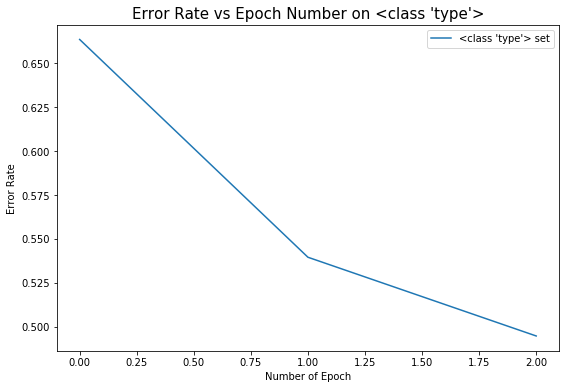

00 hours 02 minutes 01.83 seconds


In [48]:
# 1. LSTM: modify the netword to plot the error on traing as a function of num_of_epoches
re_lstm_basic = trainer(MyBasicLSTMCell, None, True)

In [49]:
# make prediction on test set
test_lstm_basic = Tester(MyBasicLSTMCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4 15
 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.63481432073
test error: 0.489299641011


In [50]:
# experiment with different priming sentenses 
Synthesize(MyBasicLSTMCell,init_string="How are you")

there are preprocessed data - lets load it
[41  3 17  0  4  7  1  0 15  3 13]
INFO:tensorflow:Restoring parameters from saved_model
data length 11
How are your land,
What thy lase it should sto but that hath and be the bady;
But is a she will or the beet the


In [51]:
Synthesize(MyBasicLSTMCell,init_string="Don't you underestimate me")

there are preprocessed data - lets load it
[47  3  8 30  2  0 15  3 13  0 13  8 12  1  7  1  6  2  9 14  4  2  1  0 14
  1]
INFO:tensorflow:Restoring parameters from saved_model
data length 26
Don't you underestimate mer,
Why seat more his son, to that I what sent a themend
And breated whith of thy sayst offecticious.


In [52]:
Synthesize(MyBasicLSTMCell,init_string="To lead a wonderful life")

there are preprocessed data - lets load it
[29  3  0 11  1  4 12  0  4  0 17  3  8 12  1  7 18 13 11  0 11  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
data length 24
To lead a wonderful life,
With shave bestake the be death, thou art we days, by thome sear
I his briding by his father be th


train_num_batches 185
epoch: 0 loss: 2.2709543879
epoch: 0 error: 0.635915540642
epoch: 1 loss: 1.83479601628
epoch: 1 error: 0.538626126341
epoch: 2 loss: 1.68728329749
epoch: 2 error: 0.500115989189


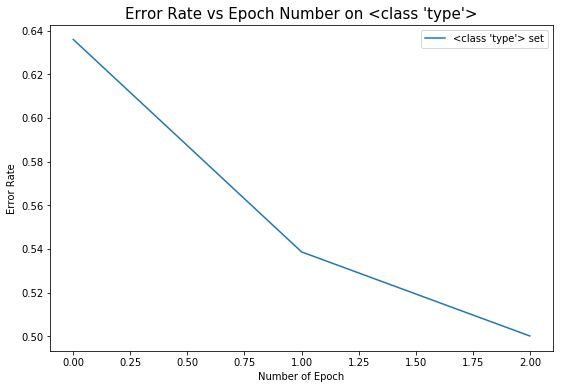

00 hours 00 minutes 50.33 seconds


In [53]:
# 2. RNN: modify the netword to plot the error on traing as a function of num_of_epoches
re_rnn_basic = trainer(MyBasicRNNCell, None, True)

In [54]:
# make prediction on test set 
test_rnn_basic = Tester(MyBasicRNNCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4 15
 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.66179060429
test error: 0.494383868385


In [56]:
# experiment with different priming sentenses 
Synthesize(MyBasicRNNCell,init_string="How are you")

there are preprocessed data - lets load it
[41  3 17  0  4  7  1  0 15  3 13]
INFO:tensorflow:Restoring parameters from saved_model
data length 11
How are yourd,
And seeds and the contens and shrake he die, my lawn but some, and his were in the charted the b


In [57]:
Synthesize(MyBasicRNNCell,init_string="Don't you underestimate me")

there are preprocessed data - lets load it
[47  3  8 30  2  0 15  3 13  0 13  8 12  1  7  1  6  2  9 14  4  2  1  0 14
  1]
INFO:tensorflow:Restoring parameters from saved_model
data length 26
Don't you underestimate met if that is, my but into them a strees mistraled of the present to trese tear and dides thing and t


In [58]:
Synthesize(MyBasicRNNCell,init_string="To lead a wonderful life")

there are preprocessed data - lets load it
[29  3  0 11  1  4 12  0  4  0 17  3  8 12  1  7 18 13 11  0 11  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
data length 24
To lead a wonderful lifes, we wall begning by trut be not senself,
O thy breathed they day this beed,
The seath make and men


#### compare models 

In general, the LSTM model behaves slightly better than RNN model in both training and test sets. However, it takes much longer to run the LSTM than RNN.

In [23]:
# c). Experiment with different models
# 1. RNN with same number of LSTM
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='/project2/cmsc25025/Shakespear/')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2*4)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=3)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()
loader = TextLoader(args.data_dir, batch_size=args.batch_size, 
                    seq_length=args.num_steps)
args.num_chars = loader.vocab_size

there are preprocessed data - lets load it


train_num_batches 185
epoch: 0 loss: 2.48199414949
epoch: 0 error: 0.667333332147
epoch: 1 loss: 1.88408136883
epoch: 1 error: 0.554885133537
epoch: 2 loss: 1.7112071295
epoch: 2 error: 0.509855854189


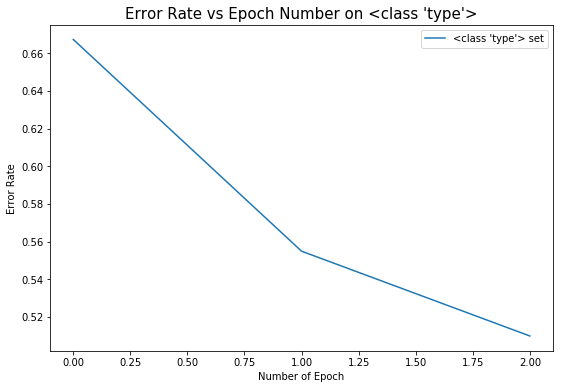

00 hours 04 minutes 46.68 seconds
there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4 15
 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.68197600639
test error: 0.503213650369


In [24]:
re_rnn_basic1 = trainer(MyBasicRNNCell, None, True)
test_rnn_basic1 = Tester(MyBasicRNNCell)

In [30]:
Synthesize(MyBasicRNNCell,init_string="So come on and try,
           try to shut me and cut me down")

there are preprocessed data - lets load it
[35  3  0 19  3 14  1  0  3  8  0  4  8 12  0  2  7 15 16  0  2  7 15  0  2
  3  0  6  5 13  2  0 14  1  0  4  8 12  0 19 13  2  0 14  1  0 12  3 17  8]
INFO:tensorflow:Restoring parameters from saved_model
data length 50
So come on and try, try to shut me and cut me downess to his never to have here a fight of the trusted fears the when, and here, who way to the trumen


there are preprocessed data - lets load it
train_num_batches 92
epoch: 0 loss: 2.49569989028
epoch: 0 error: 0.680829937398
epoch: 1 loss: 2.01304888337
epoch: 1 error: 0.583368432263
epoch: 2 loss: 1.838401499
epoch: 2 error: 0.538984375155


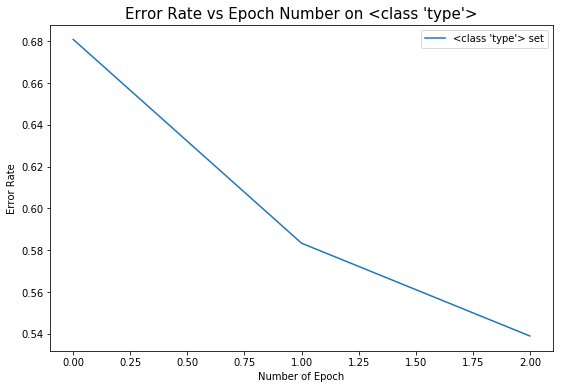

00 hours 00 minutes 56.93 seconds
there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4 15
 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 24
test loss: 1.78738658627
test error: 0.526584204286


In [31]:
# 2. RNN with changed step size (doubled)
# parser.add_argument('--num_steps', default=75*2)
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='/project2/cmsc25025/Shakespear/')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75*2)
parser.add_argument('--num_epochs', default=3)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()
loader = TextLoader(args.data_dir, batch_size=args.batch_size, 
                    seq_length=args.num_steps)
args.num_chars = loader.vocab_size
re_rnn_basic2 = trainer(MyBasicRNNCell, None, True)
test_rnn_basic2 = Tester(MyBasicRNNCell)

In [32]:
Synthesize(MyBasicRNNCell,init_string="So come on and try, 
           try to shut me and cut me down")

there are preprocessed data - lets load it
[35  3  0 19  3 14  1  0  3  8  0  4  8 12  0  2  7 15 16  0  2  7 15  0  2
  3  0  6  5 13  2  0 14  1  0  4  8 12  0 19 13  2  0 14  1  0 12  3 17  8]
INFO:tensorflow:Restoring parameters from saved_model
data length 50
So come on and try, try to shut me and cut me downe to ham shall theng but the comer and sen anceraction.
Or word, I deet be not bray as theme, that t


there are preprocessed data - lets load it
train_num_batches 92
epoch: 0 loss: 2.50254704641
epoch: 0 error: 0.682451311975
epoch: 1 loss: 2.01545318572
epoch: 1 error: 0.58548913151
epoch: 2 loss: 1.84350794683
epoch: 2 error: 0.542430932107


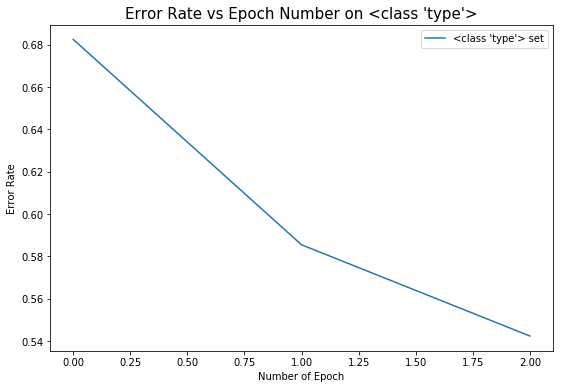

00 hours 00 minutes 41.40 seconds
there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4 15
 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 24
test loss: 1.78643634419
test error: 0.525855039557


In [33]:
# 3. RNN with doubled batch size
# change the parameter in Textloader class : batch_size=128
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='/project2/cmsc25025/Shakespear/')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64*2)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=3)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()
loader = TextLoader(args.data_dir, batch_size=args.batch_size,
                    seq_length=args.num_steps)
args.num_chars = loader.vocab_size
re_rnn_basic3 = trainer(MyBasicRNNCell, None, True)
test_rnn_basic3 = Tester(MyBasicRNNCell)

In [34]:
Synthesize(MyBasicRNNCell,init_string="So come on and try, 
           try to shut me and cut me down")

there are preprocessed data - lets load it
[35  3  0 19  3 14  1  0  3  8  0  4  8 12  0  2  7 15 16  0  2  7 15  0  2
  3  0  6  5 13  2  0 14  1  0  4  8 12  0 19 13  2  0 14  1  0 12  3 17  8]
INFO:tensorflow:Restoring parameters from saved_model
data length 50
So come on and try, try to shut me and cut me downes,
Bruen, shinks tree thou down.

Shanger will I cruesit, betest thou hasting have but that soners 


there are preprocessed data - lets load it
train_num_batches 185
epoch: 0 loss: 3.1026516974
epoch: 0 error: 0.795812498219
epoch: 1 loss: 2.3981326282
epoch: 1 error: 0.679994791001
epoch: 2 loss: 2.19750344753
epoch: 2 error: 0.630395833403


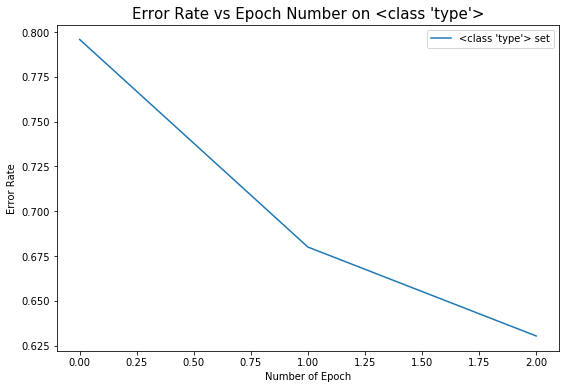

00 hours 00 minutes 33.45 seconds
there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4 15
 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 40
test loss: 2.15049799085
test error: 0.619416665286


In [35]:
# 4. LSTM with doubled number of batches
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='/project2/cmsc25025/Shakespear/')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=3)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()
loader = TextLoader(args.data_dir, batch_size=args.batch_size, 
                    seq_length=args.num_steps)
args.num_chars = loader.vocab_size
re_rnn_basic4 = trainer(MyBasicLSTMCell, 40, True)
test_rnn_basic4 = Tester(MyBasicLSTMCell, 40)

In [36]:
Synthesize(MyBasicLSTMCell,init_string="So come on and try,
           try to shut me and cut me down")

there are preprocessed data - lets load it
[35  3  0 19  3 14  1  0  3  8  0  4  8 12  0  2  7 15 16  0  2  7 15  0  2
  3  0  6  5 13  2  0 14  1  0  4  8 12  0 19 13  2  0 14  1  0 12  3 17  8]
INFO:tensorflow:Restoring parameters from saved_model
data length 50
So come on and try, try to shut me and cut me downt and whand shou sullow, wat it so toust, an sall with the wall that sourder the toor asparens and h


there are preprocessed data - lets load it
train_num_batches 185
epoch: 0 loss: 2.42549908741
epoch: 0 error: 0.673040540461
epoch: 1 loss: 1.87645444677
epoch: 1 error: 0.550708332094
epoch: 2 loss: 1.70462884967
epoch: 2 error: 0.504213963167
epoch: 3 loss: 1.60903136601
epoch: 3 error: 0.479777026982
epoch: 4 loss: 1.54623209077
epoch: 4 error: 0.463585585356


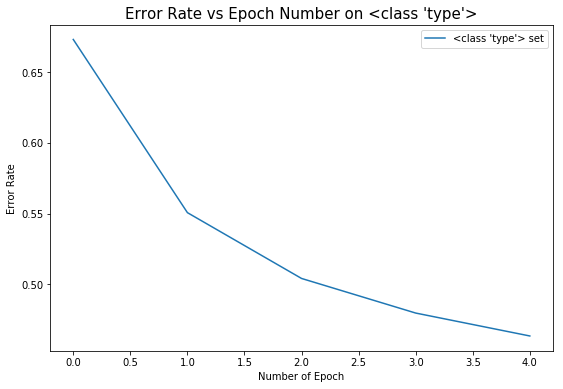

00 hours 03 minutes 42.78 seconds
there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4 15
 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.54642523096
test error: 0.464308509167


In [38]:
# 5. LSTM with number of epoches = 5
# change the parameter in parser.add_argument('--num_epochs', default=5)
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='/project2/cmsc25025/Shakespear/')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=5)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()
loader = TextLoader(args.data_dir, batch_size=args.batch_size,
                    seq_length=args.num_steps)
args.num_chars = loader.vocab_size
re_lstm_basic5 = trainer(MyBasicLSTMCell, None, True)
test_lstm_basic5 = Tester(MyBasicLSTMCell)

In [39]:
Synthesize(MyBasicLSTMCell,init_string="So come on and try, 
           try to shut me and cut me down")

there are preprocessed data - lets load it
[35  3  0 19  3 14  1  0  3  8  0  4  8 12  0  2  7 15 16  0  2  7 15  0  2
  3  0  6  5 13  2  0 14  1  0  4  8 12  0 19 13  2  0 14  1  0 12  3 17  8]
INFO:tensorflow:Restoring parameters from saved_model
data length 50
So come on and try, try to shut me and cut me downow
I have not and heavens and here is not and save the
have, that thy barn be take hith the born,
Al


As a conclusion, the LSTM model with the most number of epoches has the lowest error rate. RNN with the same number of parameter as LSTM performs the best in terms of error rate across all RNN models. Doubling the number of batches in LSTM increases the error rate significantly. 